### Generazione metadata files audio

In [8]:
import os, sys
import torch
import torchaudio
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [9]:
# parse files with generic extensions
def file_parse(root_dir, ext='', substr='', return_fullpath=False):
    file_list = []
    print(f'>> parse {root_dir}... ', end='')
    for root, _, files in os.walk(root_dir, topdown=False):
        for name in files:
            if os.path.isfile(os.path.join(root, name)) and name[-3:] == ext and substr in root:
                if return_fullpath:
                    file_list.append(os.path.join(root, name))
                else:
                    file_list.append(name)
    print(f'found {len(file_list)} {ext} files')
    return file_list

In [10]:
intell_dict={"F02": 29,
             "F03": 6,
             "F04": 65,
             "F05": 95, 
             "M01": 15,
             "M04": 2,
             "M05": 58, 
             "M07": 28,
             "M08": 93, 
             "M09": 86, 
             "M10": 93, 
             "M11": 62, 
             "M12": 7,
             "M14": 90,   
             "M16": 43,}

parse dei files originali in UA-Speech

In [11]:
flist_real = file_parse("/home/deepfake/DysarthricGAN/patients", "wav", return_fullpath=True)

df_list = []
for f in tqdm(flist_real):
    try:
        filename = os.path.join(f.split('/')[-2],f.split('/')[-1])
        intell_level = intell_dict[f.split('/')[-2]]
        filelen = torchaudio.info(f).num_frames
        df_entry = {"f_name": filename,
                    "synth": "False",
                    "len": filelen,
                    "intell_level": intell_level}
        df_list.append(df_entry)
    except:
        print(f'An error occurred while processing {f}')

df_real = pd.DataFrame(df_list)
# df.to_csv("dysarthric_data.csv", index=False)

>> parse /home/deepfake/DysarthricGAN/patients... found 11403 wav files


100%|██████████| 11403/11403 [00:00<00:00, 33269.07it/s]


parse dei files sintetici

In [12]:
flist_synth = file_parse("/home/deepfake/DysarthricGAN/patients_gen", "wav", substr="new", return_fullpath=True)

df_list = []
for f in tqdm(flist_synth):
    try:
        filename = os.path.join(f.split('/')[-2],f.split('/')[-1])
        intell_level = intell_dict[f.split('/')[-2][0:3]]
        filelen = torchaudio.info(f).num_frames
        df_entry = {"f_name": filename,
                    "synth": "True",
                    "len": filelen,
                    "intell_level": intell_level}
        df_list.append(df_entry)
    except:
        print(f'An error occurred while processing {f}')

df_synth = pd.DataFrame(df_list)


>> parse /home/deepfake/DysarthricGAN/patients_gen... found 11403 wav files


100%|██████████| 11403/11403 [00:00<00:00, 31088.41it/s]


In [13]:
df_total = pd.concat([df_real, df_synth], ignore_index=True)
# df_total.to_csv("dysarthric_metadata_audio.csv", index=False)

### Determino il valore ottimo per il pad/trim analizzando la distribuzione delle durate (nel tempo)

Mode KDE trovate:
31445.697139427888
43924.64732946589
64926.684536907385
85461.21064212843
95063.16943388678


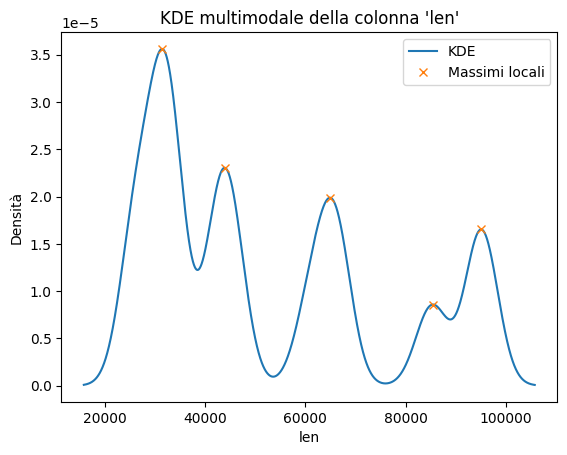

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# --- supponendo che il DataFrame si chiami df ---
data = df_total["len"].dropna().values

# 1) Calcolo KDE
kde = gaussian_kde(data)
x = np.linspace(data.min()-10000, data.max()+10000, 5000)
y = kde(x)

# 2) Ricerca dei massimi locali
# prominence serve a filtrare i picchi dovuti al rumore
peaks, properties = find_peaks(y) #, prominence=0.001)

# Valori delle mode (sull'asse x)
modes = x[peaks]

print("Mode KDE trovate:")
for m in modes:
    print(m)

# 3) Plot KDE + massimi
plt.figure()
plt.plot(x, y, label="KDE")
plt.plot(x[peaks], y[peaks], "x", label="Massimi locali")
plt.xlabel("len")
plt.ylabel("Densità")
plt.title("KDE multimodale della colonna 'len'")
plt.legend()
plt.show()


sulla base delle distribuzioni consideriamo il terzo massimo, quindi la nostra len di riferimento è 66150 (3 secondi @ sr=22050Hz)

### Playground per la generazione dei MELspectrograms

In [1]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
SAMPLE_RATE = 22050
N_FFT = 1024
HOP_LENGTH = 256
WIN_LENGTH = 1024
N_MELS = 80
F_MIN = 0.0
F_MAX = 8000.0
TARGET_FRAMES = int(3*SAMPLE_RATE)

In [4]:
def custom_mel_spectrogram(y, n_fft, n_mels, sample_rate, hop_length, win_length, f_min, f_max):
    mel_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        n_mels=n_mels,
        f_min=f_min,
        f_max=f_max,
        window_fn=torch.hann_window,
        center=False,
        pad_mode='reflect',
        power=1.0,
        norm='slaney',
        mel_scale='slaney'
    )

    mel_spec = mel_transform(y)  # [batch, n_mels, time]
    mel_spec = torch.log(torch.clamp(mel_spec, min=1e-5))

    return mel_spec

def pad_or_trim_spectrogram_batch(spec, target_frames=TARGET_FRAMES):
    batch, freq_bins, frames = spec.shape

    if frames < target_frames:
        pad_frames = target_frames - frames
        spec = F.pad(
            spec,
            pad=(0, pad_frames),
            mode="constant",
            value=0.0
        )

    elif frames > target_frames:
        spec = spec[:, :, :target_frames]

    return spec


def pad_or_trim_waveform(y, target_len):
    # pad
    if y.shape[1] < target_len:
        pad_samples = target_len - y.shape[1]
        y = F.pad(
            y,
            pad=(0, pad_samples),
            mode="constant",
            value=0.0
        )
    # trim
    elif y.shape[1] > target_len:
        y = y[..., :target_len]

    return y

In [10]:
meta_waveform = pd.read_csv("dysarthric_metadata_audio.csv")
idx = 234

In [11]:
if meta_waveform.synth.iloc[idx] == True:
    root_path = "/home/deepfake/DysarthricGAN/patients_gen"
else:
    root_path = "/home/deepfake/DysarthricGAN/patients"

y, sr = torchaudio.load(os.path.join(root_path, meta_waveform.f_name[idx]))
# pad/trim
y = pad_or_trim_waveform(y, TARGET_FRAMES).squeeze(0)
S = custom_mel_spectrogram(y, N_FFT, N_MELS, SAMPLE_RATE, HOP_LENGTH, WIN_LENGTH, F_MIN, F_MAX)
print(f'S shape: {S.shape}')

S shape: torch.Size([80, 169])


normalizzazione al volo per finalità di rappresentazione

In [12]:
mu_dis = -9
sigma_dis = 3.50
# normalizza con statistiche globali del dominio
S_norm = (S - mu_dis) / (sigma_dis + 1e-8)

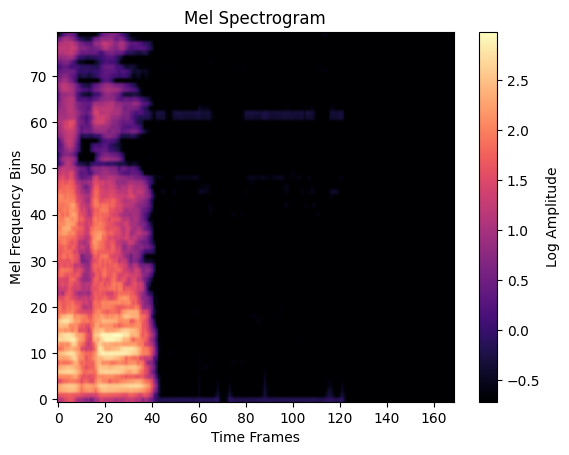

In [13]:
plt.imshow(S_norm.squeeze(0), origin='lower', aspect='auto', cmap='magma')
plt.title('Mel Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')
plt.colorbar(label='Log Amplitude')
plt.show()

### Generazione SPEC/MELSPec dataset

In [1]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
SAMPLE_RATE = 22050
N_FFT = 446
HOP_LENGTH = 256
WIN_LENGTH = 1024
N_MELS = 80
F_MIN = 0.0
F_MAX = 8000.0
TARGET_FRAMES = 57650

In [3]:
def custom_mel_spectrogram(y, n_fft, n_mels, sample_rate, hop_length, win_length, f_min, f_max):
    mel_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        n_mels=n_mels,
        f_min=f_min,
        f_max=f_max,
        window_fn=torch.hann_window,
        center=False,
        pad_mode='reflect',
        power=1.0,
        norm='slaney',
        mel_scale='slaney'
    )

    mel_spec = mel_transform(y)  # [batch, n_mels, time]
    mel_spec = torch.log(torch.clamp(mel_spec, min=1e-5))

    return mel_spec

def custom_spectrogram(y, n_fft, hop_length):
    spec_transform = T.Spectrogram(
        n_fft=n_fft,
        hop_length=hop_length,
        # win_length=win_length,
        window_fn=torch.hann_window,
        center=False,
        pad_mode='reflect',
        power=1.0
    )

    spec = spec_transform(y)  # [batch, n_mels, time]

    return torch.abs(spec)


def pad_or_trim_waveform(y, target_len):
    # pad
    if y.shape[1] < target_len:
        pad_samples = target_len - y.shape[1]
        y = F.pad(
            y,
            pad=(0, pad_samples),
            mode="constant",
            value=0.0
        )
    # trim
    elif y.shape[1] > target_len:
        y = y[..., :target_len]

    return y

In [4]:
meta_waveform = pd.read_csv("dysarthric_metadata_audio.csv")

In [5]:
meta_list = []
for idx in  tqdm(range(len(meta_waveform))):
    dest_path = "/home/deepfake/DysarthricGAN/Dys_classification/Spec_data"
    if meta_waveform.synth.iloc[idx] == True:
        root_path = "/home/deepfake/DysarthricGAN/patients_gen"
    else:
        root_path = "/home/deepfake/DysarthricGAN/patients"

    y, sr = torchaudio.load(os.path.join(root_path, meta_waveform.f_name[idx]))
    # pad/trim
    y = pad_or_trim_waveform(y, TARGET_FRAMES).squeeze(0)
    # compute MEL
    # S = custom_mel_spectrogram(y, N_FFT, N_MELS, SAMPLE_RATE, HOP_LENGTH, WIN_LENGTH, F_MIN, F_MAX)
    S = custom_spectrogram(y, N_FFT,  HOP_LENGTH)
    # preparo il dict per il metadata
    meta_dict = {
            "f_name": meta_waveform.f_name[idx][:-3] + "pth",
            "synth": meta_waveform.synth.iloc[idx],
            "intell_level": meta_waveform.intell_level.iloc[idx],
            "S_shape": list(S.shape),
            "S_mean": S.mean().item(),
            "S_dev_std": S.std().item(),
            "S_max": S.max().item(),
            "S_min": S.min().item(),
            "pat_ID": meta_waveform.f_name[idx][0:3]
        }
    meta_list.append(meta_dict)
    # salvo il MEL
    dest_path = os.path.join(dest_path, os.path.dirname(meta_dict["f_name"]))
    os.makedirs(dest_path, exist_ok=True)
    torch.save(S, os.path.join(dest_path, os.path.basename(meta_dict["f_name"])))
    
df_meta = pd.DataFrame(meta_list)
df_meta.to_csv("dysarthric_metadata_spec.csv", index=False)

100%|██████████| 22806/22806 [00:34<00:00, 664.05it/s]


### Playground per la generazione degli Sspectrograms (non MEL)

In [1]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
SAMPLE_RATE = 22050
N_FFT = 446
HOP_LENGTH = 256
# WIN_LENGTH = 1024
F_MIN = 0.0
F_MAX = 8000.0
TARGET_FRAMES = 57650

In [3]:
def custom_spectrogram(y, n_fft, hop_length):
    spec_transform = T.Spectrogram(
        n_fft=n_fft,
        hop_length=hop_length,
        # win_length=win_length,
        window_fn=torch.hann_window,
        center=False,
        pad_mode='reflect',
        power=1.0
    )

    spec = spec_transform(y)  # [batch, n_mels, time]

    return spec

def pad_or_trim_waveform(y, target_len):
    # pad
    if y.shape[1] < target_len:
        pad_samples = target_len - y.shape[1]
        y = F.pad(
            y,
            pad=(0, pad_samples),
            mode="constant",
            value=0.0
        )
    # trim
    elif y.shape[1] > target_len:
        y = y[..., :target_len]

    return y

In [4]:
meta_waveform = pd.read_csv("dysarthric_metadata_audio.csv")
idx = 234

In [5]:
if meta_waveform.synth.iloc[idx] == True:
    root_path = "/home/deepfake/DysarthricGAN/patients_gen"
else:
    root_path = "/home/deepfake/DysarthricGAN/patients"

y, sr = torchaudio.load(os.path.join(root_path, meta_waveform.f_name[idx]))
# pad/trim
y = pad_or_trim_waveform(y, TARGET_FRAMES).squeeze(0)
S = custom_spectrogram(y, N_FFT,  HOP_LENGTH)
print(f'S shape: {S.shape}')

S shape: torch.Size([224, 224])


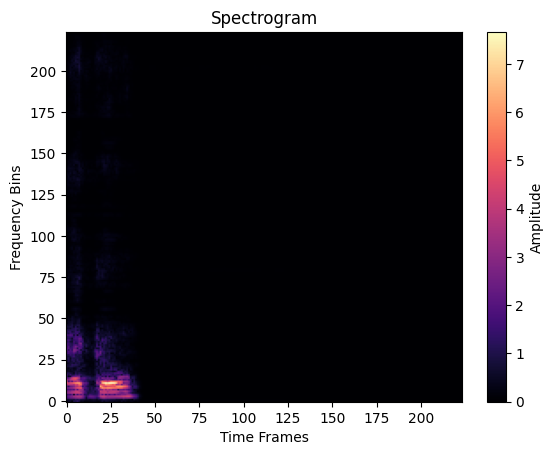

In [6]:
plt.imshow(torch.abs(S).squeeze(0)**0.5, origin='lower', aspect='auto', cmap='magma')
plt.title('Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.colorbar(label='Amplitude')
plt.show()

### Calcolo di media e varianza globali 

In [1]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

CALCOLO MEDIA E STD SOLO REAL

In [2]:
meta_spec = pd.read_csv("dysarthric_metadata_melspec.csv")


# Considera solo immagini reali
real = meta_spec[meta_spec["synth"] == False]

# Media globale
mu = real["S_mean"].mean()

# Varianza globale (formula combinata)
var = np.mean(real["S_dev_std"]**2 + (real["S_mean"] - mu)**2)

# Deviazione standard globale
sigma = np.sqrt(var)

print(f"Media globale S_mean: {mu}")
print(f"Deviazione standard globale S_dev_std: {sigma}")

Media globale S_mean: -10.0705126382108
Deviazione standard globale S_dev_std: 2.9449698462436182


CALCOLO MEDIA E STD REAL+GEN

In [3]:
meta_spec = pd.read_csv("dysarthric_metadata_melspec.csv")



# Media globale
mu = meta_spec["S_mean"].mean()

# Varianza globale (formula combinata)
var = np.mean(meta_spec["S_dev_std"]**2 + (meta_spec["S_mean"] - mu)**2)

# Deviazione standard globale
sigma = np.sqrt(var)

print(f"Media globale S_mean: {mu}")
print(f"Deviazione standard globale S_dev_std: {sigma}")

Media globale S_mean: -10.027291647480276
Deviazione standard globale S_dev_std: 2.9806488846254346
